# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

# # SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from generative_models.sgm.models.diffusion import DiffusionEngine
from omegaconf import OmegaConf

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
seed = 0
import utils

def find_paired_indices(x):
    unique_elements, counts = torch.unique(x, return_counts=True)
    repeated_elements = unique_elements[counts > 1]
    paired_indices = []
    for element in repeated_elements:
        indices = (x == element).nonzero(as_tuple=True)[0]
        for i in range(len(indices) - 1):
            for j in range(i + 1, len(indices)):
                paired_indices.append([indices[i].item(), indices[j].item()])
    return paired_indices

# Use original NSD data

In [3]:
### Load NSD subj01 betas and images from train set ###
nsd_subj01_images = np.load("/weka/proj-fmri/paulscotti/MindEye2_git/src/train_images_subj01.npy")
nsd_subj01_images = nsd_subj01_images[:688]
images = nsd_subj01_images
print("nsd_subj01_images", nsd_subj01_images.shape) # (27000, 3, 224, 224)
raw_nsd_vox = np.load("/weka/proj-fmri/paulscotti/MindEye2_git/src/train_voxels_subj01.npy")
raw_nsd_vox = raw_nsd_vox[:688]
print(raw_nsd_vox[:,0].min(), raw_nsd_vox[:,0].max(), raw_nsd_vox[:,0].mean(), raw_nsd_vox[:,0].std())
# -3.967 2.482 -0.1604 0.885
# print("nsd_subj01_voxels", nsd_subj01_voxels.shape) # (27000, 15724)
### ###
unique_idx = np.zeros(len(images), dtype=int)
first_occurrence = {}
for idx, img in enumerate(tqdm(images)):
    # Convert the image to a hashable type (e.g., bytes)
    img_bytes = img.tobytes()
    if img_bytes in first_occurrence:
        # If the image has been seen before, use the first occurrence index
        unique_idx[idx] = first_occurrence[img_bytes]
    else:
        # If the image is unique, store its index
        first_occurrence[img_bytes] = idx
        unique_idx[idx] = idx
# print(unique_idx, len(unique_idx))
### ###
# print("Loading raw nsd voxels")
# import nibabel as nib
# raw_nsd_vox = nib.load("betas_session01.nii.gz").get_fdata()
# raw_nsd_vox = np.moveaxis(raw_nsd_vox, (0,1,2,3), (1,2,3,0))
# raw_nsd_vox = torch.Tensor(raw_nsd_vox)
# raw_nsd_vox = raw_nsd_vox.flatten(1)

# roi = torch.Tensor(nib.load("nsdgeneral.nii.gz").get_fdata()).flatten()

# subj01_train_idx = np.load("/weka/proj-fmri/paulscotti/MindEye2_git/src/train_idx_subj01.npy").astype(np.int32)
# raw_nsd_vox = raw_nsd_vox[subj01_train_idx[:688]]

# raw_nsd_vox = raw_nsd_vox[:,roi==1] / 300
# print(raw_nsd_vox[:,0].min(), raw_nsd_vox[:,0].max(), raw_nsd_vox[:,0].mean(), raw_nsd_vox[:,0].std())
# # -6.05 5.08 .5409 1.5488
# print("Loaded")
### ###
# from sklearn.preprocessing import StandardScaler
# print("Z-scoring...")
# scalar = StandardScaler(with_mean=True, with_std=True).fit(raw_nsd_vox)
# betas_mean = scalar.mean_
# betas_std = scalar.scale_
# raw_nsd_vox = (raw_nsd_vox - betas_mean) / betas_std
### ###
# print("demeaning...")
# train_mean = raw_nsd_vox.mean(dim=0,keepdim=True)
# train_std = raw_nsd_vox.std(dim=0,keepdim=True)
# raw_nsd_vox = (raw_nsd_vox - train_mean) / (train_std + 1e-6)

vox = torch.Tensor(raw_nsd_vox).half()
print(vox.mean(), vox.std()) # .0783 1.0

images = torch.Tensor(images)

nsd_subj01_images (688, 3, 224, 224)
-3.967 2.482 -0.1617 0.901


100%|███████████████████████████████████████| 688/688 [00:00<00:00, 3698.47it/s]


tensor(0.0969, dtype=torch.float16) tensor(1.0166, dtype=torch.float16)


In [4]:
# plt.figure(figsize=(2,2))
# plt.imshow(images[0].permute(1,2,0).numpy())
# plt.show()
# plt.figure(figsize=(2,2))
# plt.imshow(images[1].permute(1,2,0).numpy())
# plt.show()
# plt.figure(figsize=(2,2))
# plt.imshow(images[2].permute(1,2,0).numpy())
# plt.show()

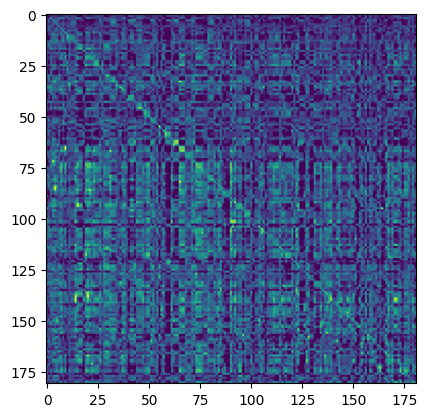

(32580,) (181,)


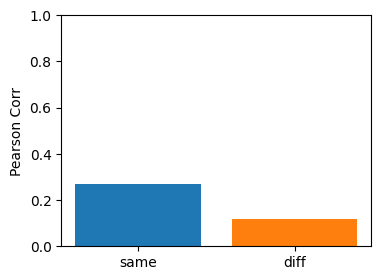

In [5]:
### ###
utils.seed_everything(1)
# vox = raw_nsd_vox
def find_paired_indices(x):
    unique_elements, counts = torch.unique(x, return_counts=True)
    repeated_elements = unique_elements[counts > 1]
    paired_indices = []
    for element in repeated_elements:
        indices = (x == element).nonzero(as_tuple=True)[0]
        for i in range(len(indices) - 1):
            for j in range(i + 1, len(indices)):
                paired_indices.append([indices[i].item(), indices[j].item()])
    return paired_indices
pairs = find_paired_indices(torch.Tensor(unique_idx))

# shuffle the pairs to get diff-image comparison
flattened_list = [item for sublist in pairs for item in sublist]
random.shuffle(flattened_list)
shuffled_pairs = [flattened_list[i:i + 2] for i in range(0, len(flattened_list), 2)]

rsm_nsd = np.zeros((len(pairs), len(pairs)))

# Compute the correlations
for i in range(len(pairs)):
    for j in range(len(pairs)):
        if i == j:
            idx1, idx2 = pairs[i]
            rsm_nsd[i, j] = np.corrcoef(vox[[idx1,idx2]])[0,1]
        else:
            # Off-diagonal: correlation for unpaired indices
            idx1_i, idx2_i = pairs[i]
            idx1_j, idx2_j = pairs[j]
            if idx1_i != idx2_j:
                rsm_nsd[i, j] = np.corrcoef(vox[[idx1_i,idx2_j]])[0,1]
            elif idx2_i != idx1_j:
                rsm_nsd[i, j] = np.corrcoef(vox[[idx2_i,idx1_j]])[0,1]
            else:
                err

plt.imshow(rsm_nsd, clim=(0,.5))
plt.show()

nsd_non_diagonal_elements = rsm_nsd[np.where(~np.eye(rsm_nsd.shape[0],dtype=bool))]
nsd_diagonal_elements = rsm_nsd[np.where(np.eye(rsm_nsd.shape[0],dtype=bool))]
print(nsd_non_diagonal_elements.shape, nsd_diagonal_elements.shape)

plt.figure(figsize=(4,3))
plt.bar(0, nsd_diagonal_elements.mean())
plt.bar(1, nsd_non_diagonal_elements.mean())
plt.ylabel("Pearson Corr")
plt.ylim([0,1])
plt.xticks([0,1],["same","diff"])
plt.show()

##### CLIP

100%|███████████████████████████████████████████| 29/29 [00:00<00:00, 45.11it/s]


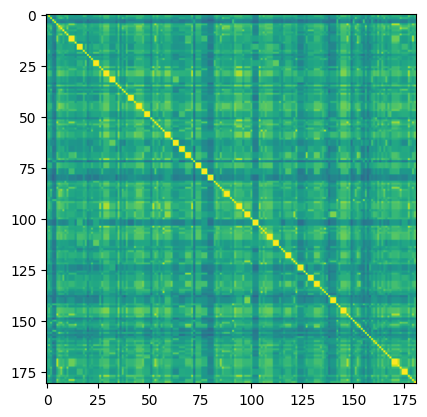

(32580,) (181,)


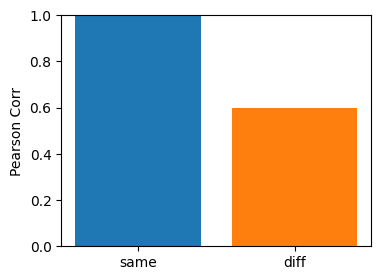

mean difference = 0.07090367050640589


In [595]:
## CLIP
utils.seed_everything(1)

clip_images = None
batch_size = 24
for i in tqdm(range(0, len(images), batch_size)):
    batch = images[i:i+batch_size]
    with torch.no_grad():
        encoded_batch = clip_model.encode_image(batch.to(device))
    if clip_images is None:
        clip_images = encoded_batch
    else:
        clip_images = torch.vstack((clip_images, encoded_batch))

vox = clip_images.cpu()

pairs = find_paired_indices(torch.Tensor(unique_idx))

# shuffle the pairs to get diff-image comparison
flattened_list = [item for sublist in pairs for item in sublist]
random.shuffle(flattened_list)
shuffled_pairs = [flattened_list[i:i + 2] for i in range(0, len(flattened_list), 2)]

rsm_nsd = np.zeros((len(pairs), len(pairs)))

# Compute the correlations
for i in range(len(pairs)):
    for j in range(len(pairs)):
        if i == j:
            idx1, idx2 = pairs[i]
            rsm_nsd[i, j] = np.corrcoef(vox[[idx1,idx2]])[0,1]
        else:
            # Off-diagonal: correlation for unpaired indices
            idx1_i, idx2_i = pairs[i]
            idx1_j, idx2_j = pairs[j]
            if idx1_i != idx2_j:
                rsm_nsd[i, j] = np.corrcoef(vox[[idx1_i,idx2_j]])[0,1]
            elif idx2_i != idx1_j:
                rsm_nsd[i, j] = np.corrcoef(vox[[idx2_i,idx1_j]])[0,1]
            else:
                err

plt.imshow(rsm_nsd, clim=(0,1))
plt.show()

nsd_non_diagonal_elements = rsm_nsd[np.where(~np.eye(rsm_nsd.shape[0],dtype=bool))]
nsd_diagonal_elements = rsm_nsd[np.where(np.eye(rsm_nsd.shape[0],dtype=bool))]
print(nsd_non_diagonal_elements.shape, nsd_diagonal_elements.shape)

plt.figure(figsize=(4,3))
plt.bar(0, nsd_diagonal_elements.mean())
plt.bar(1, nsd_non_diagonal_elements.mean())
plt.ylabel("Pearson Corr")
plt.ylim([0,1])
plt.xticks([0,1],["same","diff"])
plt.show()

print("mean difference =", same_corrs.mean() - diff_corrs.mean())

In [577]:
# # Simple classifier
# categories = [
#     "sports", "food", "animal", "person", "toy"
# ]
# categories = [f"photo of {c}" for c in categories]
# text = clip.tokenize(categories).to(device)

# semantic_cluster = []
# batch_size = 20
# with torch.no_grad():
#     text_features = clip_model.encode_text(text)
#     for i, image in enumerate(tqdm(range(0, len(images), batch_size))):
#         preproc_image = preprocess(images[i:i+batch_size]).to(device)
#         image_features = clip_model.encode_image(preproc_image)
#         for j in image_features:
#             image_probs = nn.functional.cosine_similarity(j[None], text_features)
#             image_cat = categories[torch.argmax(image_probs).item()]
#             semantic_cluster = np.append(semantic_cluster, np.where(image_cat == np.array(categories))[0].item())
# semantic_cluster = semantic_cluster.astype(np.int32)

# train_vox = vox[train_image_indices]
# test_vox = vox[test_image_indices]

# train_class = semantic_cluster[train_image_indices]
# test_class = semantic_cluster[test_image_indices]

# print("train_vox", train_vox.shape)
# print("test_vox", test_vox.shape)
# print("train_class", train_class.shape)
# print("test_class", test_class.shape)

# # train_vox torch.Size([600, 1229])
# # test_vox torch.Size([88, 1229])
# # train_class (600,)
# # test_class (88,)

# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, accuracy_score

# # Train a Support Vector Machine classifier
# clf = SVC(kernel='linear') 
# clf.fit(train_vox, train_class)

# # Predict on the test set
# pred_class = clf.predict(test_vox)
# print(pred_class)

# # Evaluate the classifier
# accuracy = accuracy_score(test_class, pred_class)
# print(f"Accuracy: {accuracy * 100:.2f}%")

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 44.02it/s]


train_vox torch.Size([600, 15724])
test_vox torch.Size([88, 15724])
train_class (600,)
test_class (88,)
[4 4 3 3 3 4 4 3 4 1 4 4 3 3 3 3 1 1 4 4 4 4 3 4 4 4 4 3 3 3 4 4 3 4 1 4 1
 4 3 1 4 4 4 1 1 1 1 1 1 4 1 1 1 1 3 4 1 4 1 4 1 1 1 3 0 4 4 1 4 4 1 1 4 1
 1 4 4 3 1 0 1 0 4 1 1 3 1 4]
Accuracy: 28.41%


# non-NSD

torch.Size([850, 3, 224, 224])
design (850, 4608)
image_idx torch.Size([1000])


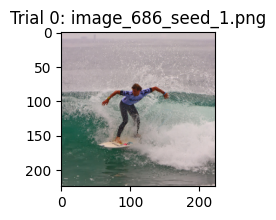

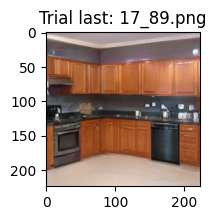

In [264]:
images, image_names = utils.load_images_to_numpy("rtmindeye_stimuli")
images = torch.Tensor(images / 255).permute(0,3,1,2) 
print(images.shape)

train_image_, test_image_, ii = [], [], 0

num_runs = 16
for r in range(num_runs):
    file_out = pd.read_csv(f"csv/design_participant1run{r}.csv")
    headers = file_out.columns.values
    values = file_out.values
    values[:,0] = 0 # remove 0th column numbering
    inds = np.argmax(values,axis=1)
    inds = inds[inds!=0]
    if r==0:
        design = file_out.to_numpy()
        images_sorted = headers[inds]
    else:
        design = np.vstack((design, file_out.to_numpy()))
        images_sorted = np.hstack((images_sorted, headers[inds]))
    for h in headers[inds]:
        if "_seed_" not in h:
            test_image_ = np.append(test_image_, ii)
        else:
            train_image_ = np.append(train_image_, ii)
        ii += 1
                
design = design[:,1:].T
print("design", design.shape)

image_idx = torch.Tensor([image_names.index(im) for im in images_sorted]).long()
print("image_idx", image_idx.shape)

# sort the images according to the experimental presentation
images = images[image_idx]

assert len(test_image_) == 100

pairs = find_paired_indices(image_idx)
pairs = np.array(sorted(pairs, key=lambda x: x[0]))

plt.figure(figsize=(2,2))
plt.imshow(images[0].permute(1,2,0).numpy())
plt.title(f"Trial 0: {image_names[image_idx[0]]}")
plt.show()
plt.figure(figsize=(2,2))
plt.imshow(images[-1].permute(1,2,0).numpy())
plt.title(f"Trial last: {image_names[image_idx[-1]]}")
plt.show()

In [346]:
# Load thresholded betas
glmsingle = np.load("glmsingle/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) #_GLMDENOISE_RR
betas = glmsingle['betasmd'][:,0,0]
r2 = glmsingle['R2'][:,0,0]
print("betas",betas.shape)
print("r2",r2.shape)
# betas = betas[r2>15]
betas = betas.T

# # Totally shuffle the betas to see what random chance is for the model
# rands = np.random.permutation(np.arange(len(betas)))
# vox = vox[rands]

# from sklearn.preprocessing import StandardScaler
# print("Z-scoring...")
# scalar = StandardScaler(with_mean=True, with_std=True).fit(betas)
# betas_mean = scalar.mean_
# betas_std = scalar.scale_
# betas = (betas - betas_mean) / betas_std

# vox creation
vox = torch.Tensor(betas)
print("vox betas after transpose and voxel exclusions",vox.shape)

# Train demeaning
# train_mean = vox.mean(dim=0, keepdim=True)
# train_std = vox.std(dim=0, keepdim=True)
# vox = (vox - train_mean) / (train_std + 1e-6)

import copy
vox_orig = copy.deepcopy(vox)

betas (165240, 1000)
r2 (165240,)
vox betas after transpose and voxel exclusions torch.Size([1000, 165240])


## Reliability

In [218]:
import nibabel as nib
brain_mask = nib.load('sub-001_ses-01_brain.nii.gz').get_fdata().flatten()
print(f"brain mask voxels = {int(brain_mask.sum())}")
roi = nib.load('sub-001_nsdgeneral.nii.gz').get_fdata()

roi = roi.flatten()
roi = roi[brain_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(f"nsdgeneral voxels = {roi.sum()}")

brain mask voxels = 165240
nsdgeneral voxels = 18419


In [219]:
vox_pairs = vox[pairs]
rels = np.full(vox.shape[-1],np.nan)
for v in tqdm(range(vox.shape[-1])):
    # reliability at a given voxel is pearson correlation between response profiles from first and second image presentations
    rels[v] = np.corrcoef(vox_pairs[:,0,v], vox_pairs[:,1,v])[1,0]

if vox.shape[-1] > roi.sum():
    print(f"num_voxels = {vox.shape[-1]}")
    rels = rels[roi==True]
    vox = vox[:,roi==True]
    print(f"num_voxels = {vox.shape[-1]}")

100%|████████████████████████████████| 165240/165240 [00:14<00:00, 11113.70it/s]


num_voxels = 165240
num_voxels = 18419


In [63]:
vox0 = np.zeros((len(pairs), vox.shape[-1], 2)) # img x vox x repetitions
for ipair, pair in enumerate(tqdm(pairs)):
    i,j = pair
    vox0[ipair, :, :] = vox[pair].T

vox0avg = vox0.mean(-1) # img x vox
# vox0avg = vox0[:,:,1]

100%|█████████████████████████████████████████| 150/150 [00:01<00:00, 85.21it/s]


In [64]:
train_mean = np.mean(vox0avg,axis=0)
train_std = np.std(vox0avg,axis=0)
vox0avg = (vox0avg - train_mean) / (train_std + 1e-6)
vox0avg.shape

(150, 18419)

In [85]:
# load NSD sub01 matrices as well
nsd_comparison_vox = np.load("raw_nsd_comparison_vox.npy") #nsd_comparison_vox
print("nsd_comparison_vox", nsd_comparison_vox.shape)

nsd_rels = np.full(nsd_comparison_vox.shape[-1],np.nan)
for v in tqdm(range(nsd_comparison_vox.shape[-1])):
    nsd_rels[v] = np.corrcoef(nsd_comparison_vox[:,0,v], 
                              nsd_comparison_vox[:,1,v])[1,0]

nsd_vox = nsd_comparison_vox.mean(1)
# nsd_vox = nsd_comparison_vox[:,1,:]

train_mean = np.mean(nsd_vox,axis=0)
train_std = np.std(nsd_vox,axis=0)
nsd_vox = (nsd_vox - train_mean) / (train_std + 1e-6)
print("nsd_vox", nsd_vox.shape)

nsd_comparison_vox (150, 2, 15724)


100%|██████████████████████████████████| 15724/15724 [00:00<00:00, 21419.22it/s]

nsd_vox (150, 15724)


In [86]:
print("Creating within-subject RDM...")
r_thresholds = np.array([.0, .1, .2, .3])
rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) # img x img
nsd_rdm = np.zeros((len(r_thresholds), len(pairs), len(pairs))) # img x img
for ir_thresh, r_thresh in enumerate(r_thresholds):
    print(f"reliability threshold = {r_thresh}")
    for i in tqdm(range(len(pairs))):
        for j in range(len(pairs)):
            rdm[ir_thresh,i,j] = np.corrcoef(vox0avg[i,rels>r_thresh], 
                                             vox0avg[j,rels>r_thresh])[0,1]
            nsd_rdm[ir_thresh,i,j] = np.corrcoef(nsd_vox[i,nsd_rels>r_thresh], 
                                                 nsd_vox[j,nsd_rels>r_thresh])[0,1]


Creating within-subject RDM...
reliability threshold = 0.0


100%|█████████████████████████████████████████| 150/150 [00:11<00:00, 13.22it/s]


reliability threshold = 0.1


100%|█████████████████████████████████████████| 150/150 [00:10<00:00, 14.01it/s]


reliability threshold = 0.2


100%|█████████████████████████████████████████| 150/150 [00:08<00:00, 18.32it/s]


reliability threshold = 0.3


100%|█████████████████████████████████████████| 150/150 [00:06<00:00, 24.04it/s]


In [87]:
# import copy
# rdm_first = copy.deepcopy(rdm)
# rdm_second = copy.deepcopy(rdm)
# nsd_rdm_first = copy.deepcopy(nsd_rdm)

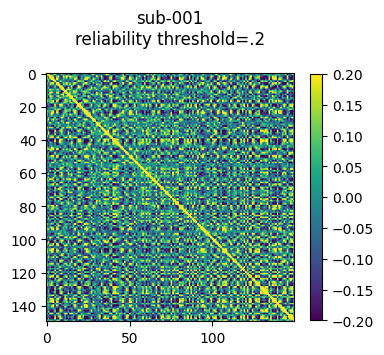

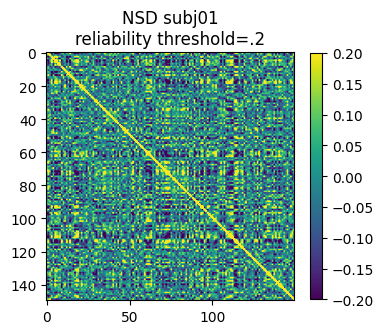

[0.00840586 0.00559348 0.00164531 0.00068027]


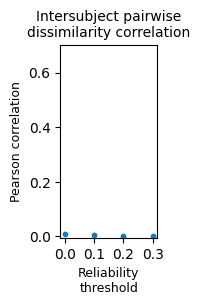

In [88]:
plt.figure(figsize=(4,4))
plt.imshow(rdm[np.where(r_thresholds==.2)[0].item()], clim=(-.2,.2))
plt.colorbar(shrink=0.8)
plt.title("sub-001\nreliability threshold=.2\n")
# plt.title("NSD subj01\nreliability threshold=.2\nFirst repetition")
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(nsd_rdm[np.where(r_thresholds==.2)[0].item()], clim=(-.2,.2))
plt.colorbar(shrink=0.8)
plt.title("NSD subj01\nreliability threshold=.2")
plt.show()

intersubject_corrs = np.zeros((len(r_thresholds)))
for ir_thresh, r_thresh in enumerate(r_thresholds):
    lower_triangle_indices = np.tril_indices(150, k=-1) # excludes diagonal
    tril_ours = rdm[ir_thresh][lower_triangle_indices]
    tril_nsd = nsd_rdm[ir_thresh][lower_triangle_indices]
    
    intersubject_corrs[ir_thresh] = np.corrcoef((tril_ours, tril_nsd))[0,1]

print(intersubject_corrs)
plt.figure(figsize=(1.25,2.5))
plt.scatter(r_thresholds,intersubject_corrs, s=10)
plt.ylabel("Pearson correlation", fontsize=9)
# plt.ylim(-0.005,.05)
plt.ylim(-0.005,.7)
plt.xlabel("Reliability\nthreshold", fontsize=9)
plt.xticks(r_thresholds)
plt.title("Intersubject pairwise\ndissimilarity correlation", fontsize=10)
plt.show()

In [128]:
# utils.seed_everything(seed)

# # shuffle the pairs to get diff-image comparison
# flattened_list = [item for sublist in pairs for item in sublist]
# random.shuffle(flattened_list)
# shuffled_pairs = [flattened_list[i:i + 2] for i in range(0, len(flattened_list), 2)]unique_paired_ids = np.unique(

# rsm_ours = np.zeros((len(pairs), len(pairs)))

# # Compute the correlations
# for i in range(len(pairs)):
#     for j in range(len(pairs)):
#         if i == j:
#             idx1, idx2 = pairs[i]
#             rsm_ours[i, j] = np.corrcoef(vox[[idx1,idx2]])[0,1]
#         else:
#             # Off-diagonal: correlation for unpaired indices
#             idx1_i, idx2_i = pairs[i]
#             idx1_j, idx2_j = pairs[j]
#             if idx1_i != idx2_j:
#                 rsm_ours[i, j] = np.corrcoef(vox[[idx1_i,idx2_j]])[0,1]
#             elif idx2_i != idx1_j:
#                 rsm_ours[i, j] = np.corrcoef(vox[[idx2_i,idx1_j]])[0,1]
#             else:
#                 err

# plt.imshow(rsm_ours, clim=(0,.5))
# plt.show()

# ours_non_diagonal_elements = rsm_ours[np.where(~np.eye(rsm_ours.shape[0],dtype=bool))]
# ours_diagonal_elements = rsm_ours[np.where(np.eye(rsm_ours.shape[0],dtype=bool))]
# print(ours_non_diagonal_elements.shape, ours_diagonal_elements.shape)

# plt.figure(figsize=(4,3))
# plt.bar(0, ours_diagonal_elements.mean())
# plt.bar(1, ours_non_diagonal_elements.mean())
# plt.ylabel("Pearson Corr")
# plt.ylim([0,1])
# plt.xticks([0,1],["same","diff"])
# plt.show()

#### CLIP and etc

100%|███████████████████████████████████████████| 42/42 [00:01<00:00, 28.28it/s]


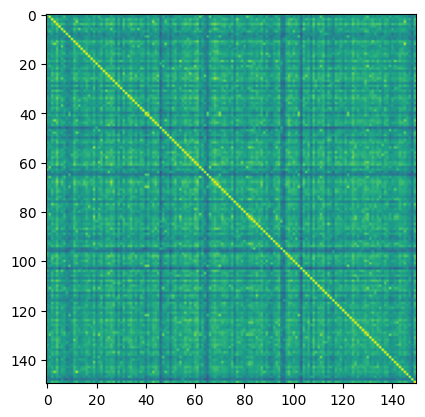

(22350,) (150,)


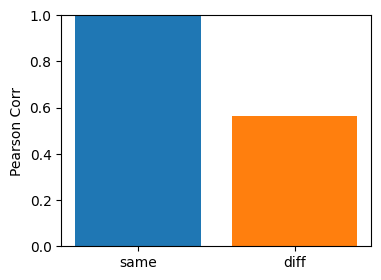

mean difference = 0.07090367050640589


In [632]:
## CLIP
utils.seed_everything(1)

clip_images = None
batch_size = 24
for i in tqdm(range(0, len(images), batch_size)):
    batch = images[i:i+batch_size]
    with torch.no_grad():
        encoded_batch = clip_model.encode_image(batch.to(device))
    if clip_images is None:
        clip_images = encoded_batch
    else:
        clip_images = torch.vstack((clip_images, encoded_batch))

vox = clip_images.cpu()

pairs = find_paired_indices(image_idx)

# shuffle the pairs to get diff-image comparison
flattened_list = [item for sublist in pairs for item in sublist]
random.shuffle(flattened_list)
shuffled_pairs = [flattened_list[i:i + 2] for i in range(0, len(flattened_list), 2)]

rsm_ours = np.zeros((len(pairs), len(pairs)))

# Compute the correlations
for i in range(len(pairs)):
    for j in range(len(pairs)):
        if i == j:
            idx1, idx2 = pairs[i]
            rsm_ours[i, j] = np.corrcoef(vox[[idx1,idx2]])[0,1]
            # display(utils.torch_to_Image(images[[idx1]]))
            # display(utils.torch_to_Image(images[[idx2]]))
            # err
        else:
            # Off-diagonal: correlation for unpaired indices
            idx1_i, idx2_i = pairs[i]
            idx1_j, idx2_j = pairs[j]
            if idx1_i != idx2_j:
                rsm_ours[i, j] = np.corrcoef(vox[[idx1_i,idx2_j]])[0,1]
            elif idx2_i != idx1_j:
                rsm_ours[i, j] = np.corrcoef(vox[[idx2_i,idx1_j]])[0,1]
            else:
                err

plt.imshow(rsm_ours, clim=(0,1))
plt.show()

ours_non_diagonal_elements = rsm_ours[np.where(~np.eye(rsm_ours.shape[0],dtype=bool))]
ours_diagonal_elements = rsm_ours[np.where(np.eye(rsm_ours.shape[0],dtype=bool))]
print(ours_non_diagonal_elements.shape, ours_diagonal_elements.shape)

plt.figure(figsize=(4,3))
plt.bar(0, ours_diagonal_elements.mean())
plt.bar(1, ours_non_diagonal_elements.mean())
plt.ylabel("Pearson Corr")
plt.ylim([0,1])
plt.xticks([0,1],["same","diff"])
plt.show()

print("mean difference =", same_corrs.mean() - diff_corrs.mean())

In [551]:
# Calculate pairwise distances for paired indices
paired_distances = None
for pair in tqdm(pairs):
    idx1, idx2 = pair
    if paired_distances is None:
        paired_distances = torch.abs(vox[idx1] - vox[idx2])[None]
    else:
        paired_distances = torch.vstack((paired_distances, torch.abs(vox[idx1] - vox[idx2])[None]))

# Calculate pairwise distances for unpaired indices
unpaired_distances = None
for i in range(len(vox)):
    for j in range(i + 1, len(vox)):
        if unpaired_distances is not None:
            if len(unpaired_distances) == len(paired_distances):
                break
        if [i, j] not in pairs and [j, i] not in pairs:
            if unpaired_distances is None:
                unpaired_distances = torch.abs(vox[i] - vox[j])[None]
            else:
                unpaired_distances = torch.vstack((unpaired_distances, torch.abs(vox[i] - vox[j])[None]))

# Calculate mean distances
mean_paired_distance = torch.median(paired_distances, dim=0).values
mean_unpaired_distance = torch.median(unpaired_distances, dim=0).values

# Calculate reliability metric for each voxel
reliability_metric = mean_unpaired_distance - mean_paired_distance

print(reliability_metric)

100%|███████████████████████████████████████| 181/181 [00:00<00:00, 3041.59it/s]

tensor([ 0.0720, -0.1333,  0.7357,  ..., -0.4051, -0.2543, -0.2446])


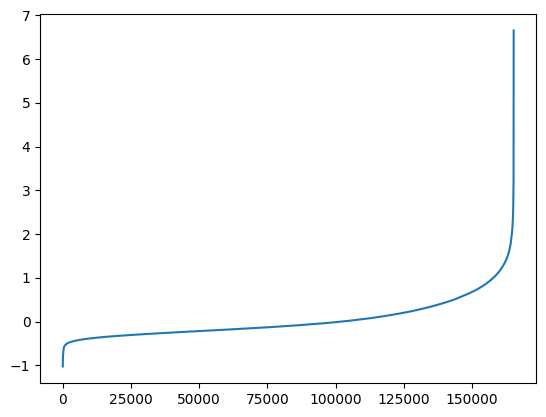

tensor(68)


In [426]:
plt.plot(np.sort(reliability_metric.cpu().numpy()))
plt.show()

subset = reliability_metric>3
print(subset.sum())

### RDM (Lizzie vs NSD subj01)

In [76]:
# nsd_subj01_images = np.load("/weka/proj-fmri/paulscotti/MindEye2_git/src/train_images_subj01.npy")
# # # raw_nsd_vox = np.load("/weka/proj-fmri/paulscotti/MindEye2_git/src/train_voxels_subj01.npy")
# nsd_subj01_images = torch.Tensor(nsd_subj01_images)

In [71]:
print("Loading raw nsd voxels")
import nibabel as nib
raw_nsd_vox = None
for session in tqdm(range(1,41)):
    if session < 10:
        temp_nsd_vox = nib.load(f"betas_session0{session}.nii.gz").get_fdata()
    else:
        temp_nsd_vox = nib.load(f"betas_session{session}.nii.gz").get_fdata()
    temp_nsd_vox = np.moveaxis(temp_nsd_vox, (0,1,2,3), (1,2,3,0))
    roi = nib.load("nsdgeneral.nii.gz").get_fdata()
    roi[roi!=1] = 0
    temp_nsd_vox = temp_nsd_vox[:,roi.astype(bool)]

    if raw_nsd_vox is None:
        raw_nsd_vox = temp_nsd_vox
    else:
        raw_nsd_vox = np.vstack((raw_nsd_vox, temp_nsd_vox))
print("raw_nsd_vox", raw_nsd_vox.shape)

Loading raw nsd voxels


100%|███████████████████████████████████████████| 40/40 [03:58<00:00,  5.96s/it]

raw_nsd_vox (30000, 15724)


In [137]:
# nsd_comparison_vox = np.load("nsd_comparison_vox.npy")
# nsd_comparison_images, image_names = utils.load_images_to_numpy("rtmindeye_stimuli")
# nsd_comparison_images = torch.Tensor(nsd_comparison_images / 255).permute(0,3,1,2) 
# print(images.shape)

In [131]:
# import time
# for im in nsd_subj01_images:
#     display(utils.torch_to_Image(im))
#     time.sleep(1)
#     clear_output(wait=True)

In [88]:
# load coco 73k indices
indices_path = "COCO_73k_subj_indices.hdf5"
hdf5_file = h5py.File(indices_path, "r")
indices = hdf5_file["subj01"][:]

f = h5py.File(f'/weka/proj-medarc/shared/mindeyev2_dataset/coco_images_224_float16.hdf5', 'r')
nsd_subj01_images = np.stack([f['images'][idx] for idx in indices])

print(nsd_subj01_images.shape)
print(raw_nsd_vox.shape)
print(images.shape)
print(vox.shape)

(30000, 3, 224, 224)
(30000, 15724)
torch.Size([1000, 3, 224, 224])
torch.Size([1000, 18419])


In [89]:
shared_images = images[pairs[:,0]]

nsd_comparison_vox = np.zeros((len(shared_images), 2, raw_nsd_vox.shape[-1]))
nsd_comparison_images = np.zeros_like(shared_images)

shared_cnt = 0
unshared_cnt = 0
no2ndk = 0
shared_occurrences = {}
for ours_i in tqdm(range(len(shared_images))):
    kk = 0
    for nsd_i in range(len(nsd_subj01_images)):        
        if torch.sum(torch.abs(shared_images[ours_i] - nsd_subj01_images[nsd_i])) < 2500:
            if kk==0:
                shared_cnt += 1
            nsd_comparison_vox[ours_i,kk] = raw_nsd_vox[nsd_i]
            nsd_comparison_images[ours_i] = shared_images[ours_i]
            kk += 1
            if kk > 1:
                break
        if nsd_i==len(nsd_subj01_images)-1:
            # print(f"none found for {ours_i}")
            unshared_cnt += 1
            if kk==1:
                no2ndk += 1

print("shared_cnt", shared_cnt)
print("unshared_cnt", unshared_cnt)
print("no2ndk", no2ndk)

# np.save("raw_nsd_comparison_vox.npy", nsd_comparison_vox)

100%|█████████████████████████████████████████| 150/150 [29:52<00:00, 11.95s/it]

shared_cnt 150
unshared_cnt 0
no2ndk 0


# Sanity model

In [552]:
train_image_indices = np.arange(600)
test_image_indices = np.arange(600,688)

# rands = np.arange(len(train_image_indices))
# np.random.shuffle(rands)
# test_image_indices = train_image_indices[rands[800:]].astype(np.int32)
# train_image_indices = train_image_indices[rands[:800]].astype(np.int32)

print(len(train_image_indices), len(test_image_indices))

600 88


In [481]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

In [574]:
# Simple classifier 
categories = [
    "sports", "food", "animal", "person", "toy"
]
categories = [f"photo of {c}" for c in categories]
text = clip.tokenize(categories).to(device)

semantic_cluster = []
batch_size = 20
with torch.no_grad():
    text_features = clip_model.encode_text(text)
    for i, image in enumerate(tqdm(range(0, len(images), batch_size))):
        preproc_image = preprocess(images[i:i+batch_size]).to(device)
        image_features = clip_model.encode_image(preproc_image)
        for j in image_features:
            image_probs = nn.functional.cosine_similarity(j[None], text_features)
            image_cat = categories[torch.argmax(image_probs).item()]
            semantic_cluster = np.append(semantic_cluster, np.where(image_cat == np.array(categories))[0].item())
semantic_cluster = semantic_cluster.astype(np.int32)

train_vox = vox[train_image_indices]
test_vox = vox[test_image_indices]

train_class = semantic_cluster[train_image_indices]
test_class = semantic_cluster[test_image_indices]

print("train_vox", train_vox.shape)
print("test_vox", test_vox.shape)
print("train_class", train_class.shape)
print("test_class", test_class.shape)

# train_vox torch.Size([600, 1229])
# test_vox torch.Size([88, 1229])
# train_class (600,)
# test_class (88,)

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train a Support Vector Machine classifier
clf = SVC(kernel='linear')  # You can change the kernel if needed
clf.fit(train_vox, train_class)

# Predict on the test set
pred_class = clf.predict(test_vox)
print(pred_class)

# Evaluate the classifier
accuracy = accuracy_score(test_class, pred_class)
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|███████████████████████████████████████████| 35/35 [00:00<00:00, 35.72it/s]


train_vox torch.Size([600, 15724])
test_vox torch.Size([88, 15724])
train_class (600,)
test_class (88,)
[4 4 3 3 3 4 4 3 4 1 4 4 3 3 3 3 1 1 4 4 4 4 3 4 4 4 4 3 3 3 4 4 3 4 1 4 1
 4 3 1 4 4 4 1 1 1 1 1 1 4 1 1 1 1 3 4 1 4 1 4 1 1 1 3 0 4 4 1 4 4 1 1 4 1
 1 4 4 3 1 0 1 0 4 1 1 3 1 4]
Accuracy: 28.41%


# Training config

In [376]:
# images = images[pairs[:,0]]
# vox = nsd_comparison_vox[:,0]
# vox = vox0[:,:,0]

# images = torch.vstack((images, images))
# vox = np.vstack((vox, nsd_comparison_vox[:,1]))
# vox = np.vstack((vox, vox0[:,:,1]))

vox = vox[:,roi]
vox = vox[:,rels>.2]
train_mean = torch.mean(vox,axis=0)
train_std = torch.var(vox,axis=0) #torch.std(vox,axis=0)
vox = (vox - train_mean) / (train_std + 1e-6)

print(images.shape)
print(vox.shape)

torch.Size([1000, 3, 224, 224])
torch.Size([1000, 3474])


In [375]:
# vox = vox - vox.min()
# vox = vox ** .5
# vox = vox - vox.mean()
# vox.std()

In [377]:
utils.seed_everything(0)
all_indices = np.random.permutation(np.arange(len(images)))
print(len(all_indices))
train_image_indices = all_indices[:int(len(images)*.8)]
test_image_indices = all_indices[int(len(images)*.8):]
print(len(train_image_indices), len(test_image_indices))

1000
800 200


In [378]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float32 # change depending on your mixed_precision

accelerator = Accelerator(split_batches=False)# mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']
batch_size = 24

LOCAL RANK  0


In [379]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
global_batch_size = batch_size * num_devices
print("global_batch_size", global_batch_size)
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 2869658
device: cuda
global_batch_size 24
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float32


# Configurations

In [380]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/weka/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} \
                    --hidden_dim=512 --clip_scale=1. \
                    --no-blurry_recon --blur_scale=.5  \
                    --no-use_prior --prior_scale=30 --no-visualize_prior \
                    --n_blocks=4 --max_lr=3e-5 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug \
                    --ckpt_interval=999 --no-ckpt_saving --no-wandb_log --new_test"# \
                    # --multisubject_ckpt=/weka/proj-fmri/paulscotti/MindEye2_git/train_logs/final_subj01_pretrained_40sess_24bs"
    # --multisubject_ckpt=../../train_logs/multisubject_subj01_1024hid_nolow_300ep_seed0"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing
--data_path=/weka/proj-fmri/shared/mindeyev2_dataset                     --model_name=testing                     --no-multi_subject --subj=1 --batch_size=24                     --hidden_dim=512 --clip_scale=1.                     --no-blurry_recon --blur_scale=.5                      --no-use_prior --prior_scale=30 --no-visualize_prior                     --n_blocks=4 --max_lr=3e-5 --mixup_pct=.33 --num_epochs=30 --no-use_image_aug                     --ckpt_interval=999 --no-ckpt_saving --no-wandb_log --new_test
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [381]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/weka/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=0,
    help="Number of training sessions to include (if multi_subject, this variable doesnt matter)",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=False,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--visualize_prior",action=argparse.BooleanOptionalAction,default=False,
    help="output visualizations from unCLIP every ckpt_interval (requires more memory!)",
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--low_mem",action=argparse.BooleanOptionalAction,default=False,
    help="whether to preload images to cpu to speed things up but consume more memory",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=2,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    import kornia.augmentation as K
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    # Define the blurring augmentations
    blur_augment = K.RandomGaussianBlur(kernel_size=(21, 21), sigma=(51.0, 51.0), p=1.)
    
if multi_subject:
    subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 0


# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [382]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    # num_samples_per_epoch = (750*num_sessions) // num_devices 
    num_samples_per_epoch = len(train_image_indices)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)

dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 24 num_iterations_per_epoch = 33 num_samples_per_epoch = 800


In [383]:
train_data = {}
train_dl = {}

train_data[f'subj0{subj}'] = torch.utils.data.TensorDataset(torch.tensor(train_image_indices))

test_data = torch.utils.data.TensorDataset(torch.tensor(test_image_indices))

In [384]:
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    # if multi_subject:
    #     train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{nsessions_allsubj[s-1]-1}" + "}.tar"
    # else:
    #     train_url = f"{data_path}/wds/subj0{s}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
    # print(train_url)
    
    # train_data[f'subj0{s}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
    #                     .shuffle(750, initial=1500, rng=random.Random(42))\
    #                     .decode("torch")\
    #                     .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
    #                     .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    train_dl = torch.utils.data.DataLoader(train_data[f'subj0{s}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

    # Load hdf5 data for betas, but don't put everything into memory
    # f = h5py.File(f'{data_path}/betas_all_subj0{s}_fp32_renorm.hdf5', 'r')
    
    # vox = f['vox'][:]
    # vox = torch.Tensor(vox).to("cpu").to(data_type)
    num_voxels_list.append(vox[0].shape[-1])
    num_voxels[f'subj0{s}'] = vox[0].shape[-1]
    voxels[f'subj0{s}'] = vox
    print(f"num_voxels for subj0{s}: {num_voxels[f'subj0{s}']}")

print("Loaded all subj train dls and vox!\n")

# Validate only on one subject
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
num_test = len(test_image_indices) # 100
# test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
# print(test_url)
# test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
#                     .shuffle(750, initial=1500, rng=random.Random(42))\
#                     .decode("torch")\
#                     .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
#                     .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=False, drop_last=True, pin_memory=True)

print(f"Loaded test dl for subj{subj}!\n")

seq_len = seq_past + 1 + seq_future
print(f"currently using {seq_len} seq_len (chose {seq_past} past behav and {seq_future} future behav)")

Training with 0 sessions
num_voxels for subj01: 3474
Loaded all subj train dls and vox!

Loaded test dl for subj1!

currently using 1 seq_len (chose 0 past behav and 0 future behav)


## Load models

### CLIP image embeddings  model

In [177]:
clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch="ViT-bigG-14",
    version="laion2b_s39b_b160k",
    output_tokens=True,
    only_tokens=True,
)
clip_img_embedder.to(device)

clip_seq_dim = 256
clip_emb_dim = 1664

# import clip
# clip_model, preprocess = clip.load("ViT-L/14", device=device)
# preprocess = transforms.Compose([
#     transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
#                          std=[0.26862954, 0.26130258, 0.27577711]),
# ])
# def clip_img_embedder(image):
#     preproc_img = preprocess(image)
#     return clip_model.encode_image(preproc_img)
# clip_seq_dim = 1
# clip_emb_dim = 768

### MindEye modules

In [385]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [386]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx=0):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,seq_len,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
1,779,200 total
1,779,200 trainable
param counts:
1,779,200 total
1,779,200 trainable
torch.Size([2, 1, 3474]) torch.Size([2, 1, 512])


In [387]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=n_blocks, drop=.15, 
                 clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        if clip_scale>0:
            self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)
            
    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
    
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
        
    def forward(self, x):
        # make empty tensors
        c,b = torch.Tensor([0.]), torch.Tensor([[0.],[0.]])
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
            
        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        if clip_scale>0:
            c = self.clip_proj(backbone)
        
        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
228,956,824 total
228,956,824 trainable
param counts:
230,736,024 total
230,736,024 trainable
b.shape torch.Size([2, 1, 512])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([1]) torch.Size([1])


### Adding diffusion prior + unCLIP if use_prior=True

In [388]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 52
    heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )

    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    
    # prep unCLIP
    if visualize_prior:
        config = OmegaConf.load("generative_models/configs/unclip6.yaml")
        config = OmegaConf.to_container(config, resolve=True)
        unclip_params = config["model"]["params"]
        network_config = unclip_params["network_config"]
        denoiser_config = unclip_params["denoiser_config"]
        first_stage_config = unclip_params["first_stage_config"]
        conditioner_config = unclip_params["conditioner_config"]
        sampler_config = unclip_params["sampler_config"]
        scale_factor = unclip_params["scale_factor"]
        disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
        offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]

        first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
        sampler_config['params']['num_steps'] = 38

        diffusion_engine = DiffusionEngine(network_config=network_config,
                               denoiser_config=denoiser_config,
                               first_stage_config=first_stage_config,
                               conditioner_config=conditioner_config,
                               sampler_config=sampler_config,
                               scale_factor=scale_factor,
                               disable_first_stage_autocast=disable_first_stage_autocast)
        # set to inference
        diffusion_engine.eval().requires_grad_(False)
        diffusion_engine.to(device)

        ckpt_path = '/weka/proj-fmri/shared/mindeyev2_dataset/unclip6_epoch0_step110000.ckpt'
        ckpt = torch.load(ckpt_path, map_location='cpu')
        diffusion_engine.load_state_dict(ckpt['state_dict'])

        image = images[:1].to(device)
        batch={"jpg": image,
              "original_size_as_tuple": torch.ones(image.shape[0], 2).to(device) * 768,
              "crop_coords_top_left": torch.zeros(image.shape[0], 2).to(device)}
        out = diffusion_engine.conditioner(batch)
        vector_suffix = out["vector"].to(device)
        print("vector_suffix", vector_suffix.shape)

### Setup optimizer / lr / ckpt saving

In [389]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
# model.backbone.requires_grad_(False)
if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = accelerator.unwrap_model(model)
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(outdir+'/last.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 990

Done with model preparations!
param counts:
230,736,024 total
230,736,024 trainable


# Weights and Biases

In [390]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'rtmindeye'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume="allow",
    )
else:
    wandb_log = False

# Main

In [391]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [392]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

In [393]:
# checkpoint = torch.load(multisubject_ckpt+'/last.pth', map_location='cpu')
# state_dict = checkpoint['model_state_dict']
# model.load_state_dict(state_dict, strict=False)

In [394]:
# load saved ckpt model weights into current model
if resume_from_ckpt:
    load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)
elif wandb_log:
    if wandb.run.resumed:
        load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)

In [395]:
# train_dls = [train_dl[f'subj0{s}'] for s in subj_list]

model, optimizer, train_dl, lr_scheduler = accelerator.prepare(model, optimizer, train_dl, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

In [396]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))
skip_train = True if epoch>=(num_epochs-1) else False # skip training if you are resuming from a fully trained model

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    test_recon_cossim = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    test_loss_prior_total = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i, behav in enumerate(train_dl):  
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss = 0.
            
            behav = behav[0]

            image = images[behav.long().cpu()].to(device)
            voxel = vox[behav.long().cpu()]
            # voxel = (voxel - train_mean) / train_std
            voxel = torch.Tensor(voxel).unsqueeze(1).to(device)

            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            voxel_ridge = model.ridge(voxel,0) #[model.ridge(voxel_list[si],si) for si,s in enumerate(subj_list)]
            # voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                image_norm = (image - mean)/std
                image_aug = (blur_augs(image) - mean)/std
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()
            
            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()
                
            if train_i >= num_iterations_per_epoch-1:
                break
                
    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, behav in enumerate(test_dl):  
                behav = behav[0]
                # assert len(behav) == num_test

                loss=0.
                
                image = images[behav.long().cpu()].to(device)
                voxel = vox[behav.long().cpu()]
                # voxel = (voxel - train_mean) / train_std
                voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
                
                if use_image_aug: 
                    image = img_augment(image)

                clip_target = clip_img_embedder(image.float())
                
                voxel_ridge = model.ridge(voxel,0)

                backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                
                if use_prior:
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                    
                    if visualize_prior:
                        # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                        prior_out = model.diffusion_prior.p_sample_loop(backbone[random_samps].shape, 
                                        text_cond = dict(text_embed = backbone[random_samps]), 
                                        cond_scale = 1., timesteps = timesteps)

                        test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target[random_samps]).mean().item()
                        test_recon_mse += mse(prior_out, clip_target[random_samps]).item()
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)

                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, _ = blurry_image_enc_
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            if skip_train: break
            print("---")

            # assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    if wandb_log:
                        logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
                        
                if use_prior and visualize_prior: # output recons every ckpt
                    idx = np.random.randint(0, 3)
                    print(f"reconstructing... idx={idx}")
                    samples = utils.unclip_recon(prior_out[[idx]],
                             diffusion_engine,
                             vector_suffix)
                    if wandb_log:
                        logs[f"test/orig"] = wandb.Image(transforms.ToPILImage()(image[idx]),
                                                           caption=f"epoch{epoch:03d}")
                        logs[f"test/recons"] = wandb.Image(transforms.ToPILImage()(samples[0]),
                                                           caption=f"epoch{epoch:03d}")
                    if utils.is_interactive():
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(image[idx]))
                        plt.axis('off')
                        plt.show()
                        
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')

testing starting with epoch 0 / 30


  3%|██████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 1/30 [00:06<03:11,  6.59s/it, test/blurry_pixcorr=0, test/loss=3.29, test/loss_clip_total=3.29, test/loss_prior=0, test/num_steps=8, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.0417, train/blurry_pixcorr=0, train/bwd_pct_correct=0.0404, train/fwd_pct_correct=0.0341, tr

---


  7%|████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 2/30 [00:12<02:59,  6.42s/it, test/blurry_pixcorr=0, test/loss=3.23, test/loss_clip_total=3.23, test/loss_prior=0, test/num_steps=16, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0521, test/test_fwd_pct_correct=0.0729, train/blurry_pixcorr=0, train/bwd_pct_correct=0.126, train/fwd_pct_correct=0.355,

---


 10%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 3/30 [00:19<02:52,  6.37s/it, test/blurry_pixcorr=0, test/loss=3.19, test/loss_clip_total=3.19, test/loss_prior=0, test/num_steps=24, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0521, test/test_fwd_pct_correct=0.0885, train/blurry_pixcorr=0, train/bwd_pct_correct=0.51, train/fwd_pct_correct=0.628, tr

---


 13%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 4/30 [00:25<02:45,  6.35s/it, test/blurry_pixcorr=0, test/loss=3.17, test/loss_clip_total=3.17, test/loss_prior=0, test/num_steps=32, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0521, test/test_fwd_pct_correct=0.13, train/blurry_pixcorr=0, train/bwd_pct_correct=0.684, train/fwd_pct_correct=0.668, tra

---


 17%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 5/30 [00:31<02:38,  6.32s/it, test/blurry_pixcorr=0, test/loss=3.14, test/loss_clip_total=3.14, test/loss_prior=0, test/num_steps=40, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0833, test/test_fwd_pct_correct=0.13, train/blurry_pixcorr=0, train/bwd_pct_correct=0.734, train/fwd_pct_correct=0.706, train

---


 20%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 6/30 [00:38<02:31,  6.31s/it, test/blurry_pixcorr=0, test/loss=3.12, test/loss_clip_total=3.12, test/loss_prior=0, test/num_steps=48, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.0938, test/test_fwd_pct_correct=0.141, train/blurry_pixcorr=0, train/bwd_pct_correct=0.749, train/fwd_pct_correct=0.717, train

---


 23%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 7/30 [00:44<02:24,  6.30s/it, test/blurry_pixcorr=0, test/loss=3.1, test/loss_clip_total=3.1, test/loss_prior=0, test/num_steps=56, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.13, test/test_fwd_pct_correct=0.141, train/blurry_pixcorr=0, train/bwd_pct_correct=0.755, train/fwd_pct_correct=0.701, train

---


 27%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 8/30 [00:50<02:18,  6.30s/it, test/blurry_pixcorr=0, test/loss=3.1, test/loss_clip_total=3.1, test/loss_prior=0, test/num_steps=64, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.12, test/test_fwd_pct_correct=0.135, train/blurry_pixcorr=0, train/bwd_pct_correct=0.779, train/fwd_pct_correct=0.729, train

---


 30%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 9/30 [00:56<02:12,  6.29s/it, test/blurry_pixcorr=0, test/loss=3.1, test/loss_clip_total=3.1, test/loss_prior=0, test/num_steps=72, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.151, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.73, train/fwd_pct_correct=0.701, train

---


 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 10/30 [01:03<02:05,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.1, test/loss_clip_total=3.1, test/loss_prior=0, test/num_steps=80, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.125, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                     | 11/30 [01:09<01:59,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.09, test/loss_clip_total=3.09, test/loss_prior=0, test/num_steps=88, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.146, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/

---


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                              | 12/30 [01:15<01:53,  6.29s/it, test/blurry_pixcorr=0, test/loss=3.09, test/loss_clip_total=3.09, test/loss_prior=0, test/num_steps=96, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.135, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                         | 13/30 [01:22<01:46,  6.29s/it, test/blurry_pixcorr=0, test/loss=3.09, test/loss_clip_total=3.09, test/loss_prior=0, test/num_steps=104, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, trai

---


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                  | 14/30 [01:28<01:40,  6.29s/it, test/blurry_pixcorr=0, test/loss=3.09, test/loss_clip_total=3.09, test/loss_prior=0, test/num_steps=112, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.13, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                           | 15/30 [01:34<01:34,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.09, test/loss_clip_total=3.09, test/loss_prior=0, test/num_steps=120, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                     | 16/30 [01:40<01:27,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=128, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.135, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/

---


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                               | 17/30 [01:47<01:21,  6.26s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=136, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                         | 18/30 [01:53<01:15,  6.26s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=144, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.167, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                    | 19/30 [01:59<01:09,  6.27s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=152, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, trai

---


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                             | 20/30 [02:05<01:02,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=160, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.177, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                       | 21/30 [02:12<00:56,  6.27s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=168, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.177, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                | 22/30 [02:18<00:50,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=176, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 23/30 [02:24<00:43,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=184, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.177, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 24/30 [02:31<00:37,  6.28s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=192, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 25/30 [02:37<00:31,  6.29s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=200, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/

---


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 26/30 [02:43<00:25,  6.29s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=208, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 27/30 [02:49<00:18,  6.30s/it, test/blurry_pixcorr=0, test/loss=3.08, test/loss_clip_total=3.08, test/loss_prior=0, test/num_steps=216, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.146, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train/l

---


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 28/30 [02:56<00:12,  6.32s/it, test/blurry_pixcorr=0, test/loss=3.07, test/loss_clip_total=3.07, test/loss_prior=0, test/num_steps=224, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.141, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train

---


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 29/30 [03:02<00:06,  6.32s/it, test/blurry_pixcorr=0, test/loss=3.07, test/loss_clip_total=3.07, test/loss_prior=0, test/num_steps=232, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.141, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, train

---


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:09<00:00,  6.30s/it, test/blurry_pixcorr=0, test/loss=3.07, test/loss_clip_total=3.07, test/loss_prior=0, test/num_steps=240, test/recon_cossim=0, test/recon_mse=0, test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.141, train/blurry_pixcorr=0, train/bwd_pct_correct=0.994, train/fwd_pct_correct=0.994, trai

---

===Finished!===



In [374]:
# test/test_bwd_pct_correct=0.625, test/test_fwd_pct_correct=0.742

In [ ]:
# batch size 24
# 512 hidden, no pretrained, 3e-5 max_lr
# 20 epochs: test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.167,
# 30 epochs:  test/test_bwd_pct_correct=0.172, test/test_fwd_pct_correct=0.177
# with z-score: exactly the same
# with use_prior: test/test_bwd_pct_correct=0.109, test/test_fwd_pct_correct=0.104
# batch_size 64 instead of 24:  test/test_bwd_pct_correct=0.177, test/test_fwd_pct_correct=0.172
# fp32 instead of fp16: no difference
# 1024 hidden no pretrained: test/test_bwd_pct_correct=0.151, test/test_fwd_pct_correct=0.141
# 1024 hidden with multisubject pretrained: test/test_bwd_pct_correct=0.0729, test/test_fwd_pct_correct=0.0833
# 1024 hidden only training the ridge, not using multisubj pretrained: test/test_bwd_pct_correct=0.0573, test/test_fwd_pct_correct=0.177
# 1024 hidden only training the ridge, using multisubj pretrained: test/test_bwd_pct_correct=0.0625, test/test_fwd_pct_correct=0.099
# 512 hidden only training the ridge, not using multisubj pretrained: test/test_bwd_pct_correct=0.0417, test/test_fwd_pct_correct=0.135

# nsdgeneral voxels
# 512 hidden, no pretrained, 3e-5: test/test_bwd_pct_correct=0.193, test/test_fwd_pct_correct=0.161

# nsd
# 3e-4 hidden=512 test/test_bwd_pct_correct=0.433, test/test_fwd_pct_correct=0.6
# hidden=1024 w/ multisubject pretrained  test/test_bwd_pct_correct=0.608, test/test_fwd_pct_correct=0.65
# hidden=512 w/o multisubject pretrained test/test_bwd_pct_correct=0.325, test/test_fwd_pct_correct=0.375

In [27]:
# model.eval()
# if local_rank==0:
#     with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
#         for test_i, behav in enumerate(test_dl):  
#             behav = behav[0][-10:]
#             # assert len(behav) == num_test

#             loss=0.
            
#             image = images[behav.long().cpu()].to(device)
#             voxel = vox[behav.long().cpu()]
#             # voxel = (voxel - train_mean) / train_std
#             voxel = torch.Tensor(voxel).unsqueeze(1).to(device)
            
#             if use_image_aug: 
#                 image = img_augment(image)

#             clip_target = clip_img_embedder(image.float())
            
#             voxel_ridge = model.ridge(voxel,0)

#             backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

#             # for some evals, only doing a subset of the samples per batch because of computational cost
#             random_samps = np.arange(len(image))
            
#             loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                
#             # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
#             prior_out = model.diffusion_prior.p_sample_loop(backbone[random_samps].shape, 
#                             text_cond = dict(text_embed = backbone[random_samps]), 
#                             cond_scale = 1., timesteps = timesteps)

#             err

In [28]:
# random chance is test/loss=4.8 test/test_bwd_pct_correct=0.06, test/test_fwd_pct_correct=0.02
# not random chance so far is test/loss=4.65 test/test_bwd_pct_correct=0.06, test/test_fwd_pct_correct=0.05

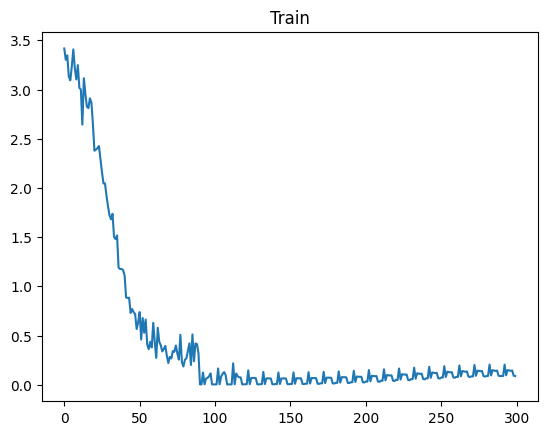

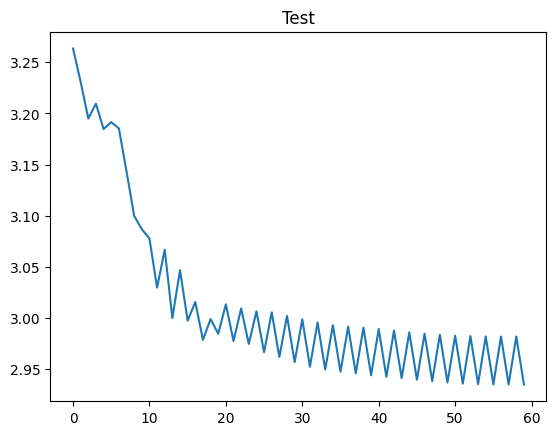

In [211]:
plt.plot(losses)
plt.title("Train")
plt.show()
plt.plot(test_losses)
plt.title("Test")
plt.show()